# LINFA Tutorial
LINFA is a library for variational inference with normalizing flow and adaptive annealing. It is designed to accommodate computationally expensive models and difficult-to-sample posterior distributions with dependent parameters.

### Tutorial Process
1. Define model (problem set) to apply **LINFA**
2. Check if gradients of model match with pytorch gradient calculation
3. Apply model to no *NOFAS* (without using the surrogate)
4. Apply *NOFAS* to model enabling the surrogate 
5. Analyze results 

### Additional Resources

#### Background theory and examples for LINFA
* Y. Wang, F. Liu and D.E. Schiavazzi, Variational Inference with NoFAS: Normalizing Flow with Adaptive Surrogate for Computationally Expensive Models: https://www.sciencedirect.com/science/article/abs/pii/S0021999122005162
* E.R. Cobian, J.D. Hauenstein, F. Liu and D.E. Schiavazzi, AdaAnn: Adaptive Annealing Scheduler for Probability Density Approximation:
https://www.dl.begellhouse.com/journals/52034eb04b657aea,796f39cb1acf1296,6f85fe1149ff41d9.html?sgstd=1


#### More about LINFA library: 
* LINFA library documentation: https://linfa-vi.readthedocs.io/en/latest/index.html

In [1]:
## Import libraries ##
import os
from linfa.run_experiment import experiment
from linfa.transform import Transformation
from linfa.nofas import Surrogate
import torch
import random
import numpy as np
import math
from torch.autograd import Variable
import pandas as pd
from matplotlib import pyplot as plt

### 1. Define Model (Problem Set)
* We define the Physics model: **Phys**, a simple traditional physics problem set, specifically dealing with trajectory motion of an object, where we calculate the: 
    * `maximum height (m)` 
    * `final location (m)`
    * `total time of the entire trajectory motion (s)`
    
    given the: 
    * `starting position (m)`
    * `initial velocity (m/s)`
    * `Angle (degrees)`
<br>

* Under our model **Phys** class, we define three functions: 
    * `__init__`: The constructor function. Class variables are defined.
    * `genDataFile`: The data file generator function. 
    * `solve_t`: The solver function.
    * *check comments for detailed documentation.* 

In [2]:
#### Implementation of the traditional trajectory motion physics problem ####
class Phys:
    
    ### Define constructor function for Phys class ###
    def __init__(self):
        ## Define input parameters (True value)  
        # input[] = [starting_position, initial_velocity, angle] = [1(m), 5(m/s), 60(degs)]
        self.defParam = torch.Tensor([[1.0, 5.0, 60.0]])

        self.gConst = 9.81   # gravitational constant
        self.stdRatio = 0.05 # standard deviation ratio
        self.data = None     # data set of model sample

    ### Define data file generator function###
    # dataSize (int): size of sample (data)
    # dataFileName (String): name of the sample data file
    # store (Boolean): True if user wish to store the generated data file; False otherwise.
    def genDataFile(self, dataSize = 50, dataFileName="data_phys.txt", store=True):
        def_out = self.solve_t(self.defParam)[0]
        print(def_out)
        self.data = def_out + self.stdRatio * torch.abs(def_out) * torch.normal(0, 1, size=(dataSize, 3))
        self.data = self.data.t().detach().numpy()
        if store: np.savetxt(dataFileName, self.data)
        return self.data

    ### Define data file generator function###
    # params (Tensor): input parameters storing starting position, initial velocity, and angle in corresponding order.
    def solve_t(self, params):
        z1, z2, z3 = torch.chunk(params, chunks=3, dim=1) # input parameters
        z3 = z3 * (np.pi / 180)                           # convert unit from degree to radians
        
        ## Output value calculation
        # ouput[] = [maximum_height, final_location, total_time]
        x = torch.cat(( (z2 * z2 * torch.sin(z3) * torch.sin(z3)) / (2.0 * self.gConst),  # x1: maxHeight
            z1 + ((z2 * z2 * torch.sin(2.0 * z3)) / self.gConst),                         # x2: finalLocation 
            (2.0 * z2 * torch.sin(z3)) / self.gConst), 1)   
        return x

In [3]:
## Generate phys sample file ##

# Define model
model = Phys()

# Generate Data
physData = model.genDataFile()

tensor([0.9557, 3.2070, 0.8828])


### 2. Check for Gradient Calculation
* Prior to applying NOFAS to our Phys model, we need to check if the gradient calculated by our model matches the gradient calculated by PyTorch to ensure it's functionality without including the surrogate. 
* Specifically, when surrogate is not enabled, gradient calculation is completed straight through the model so we want to ensure that the model is capable to calculate the correct gradients before applying NOFAS.
* In this step, we compute each gradient using (1) Pytorch and the (2) Phys model and compare the values to ensure model functionality.
* We proceed with the following order:
    1) Gradient Calculation with PyTorch
    2) Gradient Calculation by Phys Model itself
    

 ##### (1) Gradient calculation with PyTorch ver 1

In [9]:
#### Implementation of gradient calculation using PyTorch - version 1 #### 
class PytorchGrad1: 
    ### Define constructor function for PytorchGrad1 class ###
    def __init__(self):
        # Define gravitational constant
        self.gConst = 9.81
        
        # Define each input manually so that it enables gradient calculation
        self.z1 = torch.tensor(1.0, requires_grad = True)
        self.z2 = torch.tensor(5.0, requires_grad = True)
        self.z3 = torch.tensor(60.0 * np.pi / 180, requires_grad = True)
        
        # Define each output manually reflecting the inputs above
        self.x1 = (self.z2 ** 2) * (torch.sin(self.z3) ** 2) / (2.0 * self.gConst) 
        self.x2 = self.z1 + ((self.z2 ** 2) * torch.sin(2.0 * self.z3)) / self.gConst 
        self.x3 = (2.0 * self.z2 * torch.sin(self.z3)) / self.gConst

    ### Compute gradients using backward function ###
    def back_x1(self): 
        self.x1.backward()
        dz1 = self.z1.grad
        dz2 = self.z2.grad
        dz3 = self.z3.grad
        return [dz1, dz2, dz3]
    
    def back_x2(self): 
        self.x2.backward()
        dz1 = self.z1.grad
        dz2 = self.z2.grad
        dz3 = self.z3.grad
        return [dz1, dz2, dz3]
    
    def back_x3(self): 
        self.x3.backward()
        dz1 = self.z1.grad
        dz2 = self.z2.grad
        dz3 = self.z3.grad
        return [dz1, dz2, dz3]
        

In [10]:
## Gradient calculation with PyTorch ver 1

# List to store dx/dz values
dx_dz_pytorch1 = []           

# Set pytorchGrad1 object
pyGrad1 = PytorchGrad1()
# Calculate gradient and add to list
dx_dz_pytorch1.append(pyGrad1.back_x1())

# Reset pytorchGrad1 object
pyGrad1 = PytorchGrad1()
# Calculate gradient and add to list
dx_dz_pytorch1.append(pyGrad1.back_x2())

# Reset pytorchGrad1 object
pyGrad1 = PytorchGrad1()
# Calculate gradient and add to list
dx_dz_pytorch1.append(pyGrad1.back_x3())

# print(dx_dz_pytorch1[1]) # check if values match as expected

# Convert to pandas-DataFrame for readability
jacob_mat_1 = pd.DataFrame(dx_dz_pytorch1, columns=['dz1', 'dz2', 'dz3'])
jacob_mat_1.index = ['dx1', 'dx2', 'dx3']
jacob_mat_1

,dz1,dz2,dz3
dx1,None,tensor(0.3823),tensor(1.1035)
dx2,tensor(1.),tensor(0.8828),tensor(-2.5484)
dx3,None,tensor(0.1766),tensor(0.5097)


 ##### (1) Gradient calculation with PyTorch ver 2

In [5]:
#### Implementation of gradient calculation using PyTorch - version 2 #### 
class PytorchGrad2: 
    ### Define constructor function for PytorchGrad2 class ###
    def __init__(self, model, transform):
        # Define input parameters and enable gradient calculation
        self.z = torch.Tensor([[1.0, 5.0, 60.0]])
        self.z.requires_grad = True
        
        self.in_vals = torch.from_numpy(transform.forward(self.z).detach().numpy())
        #self.in_vals = self.z
        self.in_vals.requires_grad = True 

        self.out_val = model.solve_t(self.in_vals)
        self.out1, self.out2, self.out3 = torch.chunk(self.out_val, chunks=3, dim=1)

    # Compute gradients using backward function for y
    def back_x1(self): 
        self.out1.backward()
        d1 = self.in_vals.grad
        a, b, c = torch.chunk(d1, chunks=3, dim=1)
        return [a, b, c]
    
    def back_x2(self): 
        self.out2.backward()
        d2 = self.in_vals.grad
        a, b, c = torch.chunk(d2, chunks=3, dim=1)
        return [a, b, c]
    
    def back_x3(self): 
        self.out3.backward()
        d3 = self.in_vals.grad
        a, b, c = torch.chunk(d3, chunks=3, dim=1)
        return [a, b, c]
        

In [6]:
# Define Phys model
model = Phys()
# Set transformation information and define transforamtion
trsf_info = [['identity',0.0,0.0,0.0,0.0],
        ['identity',0,0.0,0.0,0.0],
        ['identity',0,0.0,0.0,0.0]]
        # ['linear',-3,3,30.0,80.0]]
        
transform = Transformation(trsf_info)

# List to store dx/dz values
dx_dz_pytorch2 = []

# Define PytorchGrad object and calculate gradient
pyGrad2 = PytorchGrad2(model, transform)
dx_dz_pytorch2.append(pyGrad2.back_x1())

pyGrad2 = PytorchGrad2(model, transform)
dx_dz_pytorch2.append(pyGrad2.back_x2())

pyGrad2 = PytorchGrad2(model, transform)
dx_dz_pytorch2.append(pyGrad2.back_x3())

# print(dx_dz_pytorch2) # check if output matches expectations

# convert to pandas DataFrame for readability
jacob_mat_2 = pd.DataFrame(dx_dz_pytorch2, columns=['dz1', 'dz2', 'dz3'])
jacob_mat_2.index = ['dx1', 'dx2', 'dx3']
jacob_mat_2

,dz1,dz2,dz3
dx1,[[tensor(0.)]],[[tensor(0.3823)]],[[tensor(0.0193)]]
dx2,[[tensor(1.)]],[[tensor(0.8828)]],[[tensor(-0.0445)]]
dx3,[[tensor(0.)]],[[tensor(0.1766)]],[[tensor(0.0089)]]


##### (2) Manual gradient calculation with Phys Model

In [7]:
### Function that manually calculates a derivative ###
def getGrad(f_eps, f, eps):
    return (f_eps - f) / (eps)

### Function that returns a list of gradients ###
def gradList(f_eps1, f_eps2, f_eps3, f, eps): 
    return [getGrad(f_eps1, f, eps), getGrad(f_eps2, f, eps), getGrad(f_eps3, f, eps)]

In [8]:
# List to store dx/dz values
dx_dz = []
dx1_dz = []
dx2_dz = []
dx3_dz = []

# Set up parameters
eps = 3.5    
z = torch.Tensor([[1.0, 5.0, 60.0]])
z_eps1 = torch.Tensor([[1.0 + eps, 5.0, 60.0]])
z_eps2 = torch.Tensor([[1.0, 5.0 + eps, 60.0]])
z_eps3 = torch.Tensor([[1.0, 5.0, 60.0 + eps]])

x1_eps1 = model.solve_t(z_eps1)[0,0]
x1_eps2 = model.solve_t(z_eps2)[0,0]
x1_eps3 = model.solve_t(z_eps3)[0,0]
x1_eps = model.solve_t(z)[0,0]

dx1_dz = gradList(x1_eps1, x1_eps2, x1_eps3, x1_eps, eps)
dx_dz.append(dx1_dz)

x2_eps1 = model.solve_t(z_eps1)[0,1]
x2_eps2 = model.solve_t(z_eps2)[0,1]
x2_eps3 = model.solve_t(z_eps3)[0,1]
x2_eps = model.solve_t(z)[0,1]

dx2_dz = gradList(x2_eps1, x2_eps2, x2_eps3, x2_eps, eps)
dx_dz.append(dx2_dz)

x3_eps1 = model.solve_t(z_eps1)[0,2]
x3_eps2 = model.solve_t(z_eps2)[0,2]
x3_eps3 = model.solve_t(z_eps3)[0,2]
x3_eps = model.solve_t(z)[0,2]

dx3_dz = gradList(x3_eps1, x3_eps2, x3_eps3, x3_eps, eps)
dx_dz.append(dx3_dz)

# print(dx_dz) # check if values match expected outputs

# convert to pandas DataFrame for readability
jacob_mat_3 = pd.DataFrame(dx_dz, columns=['dz1', 'dz2', 'dz3'])
jacob_mat_3.index = ['dx1', 'dx2', 'dx3']
jacob_mat_3

,dz1,dz2,dz3
dx1,tensor(0.),tensor(0.5161),tensor(0.0185)
dx2,tensor(1.),tensor(1.1918),tensor(-0.0491)
dx3,tensor(0.),tensor(0.1766),tensor(0.0084)


##### We focus on dx2_dz3 to check if it converges to the Pytorch gradient value
- Note: adjust values to check convergence for other gradients of interest

In [11]:
## Focus: dx2_dz3

initial_eps = 15        # Initial change of value (eps)
k = 150                 # Number of iterations
dx2_dz3_list = []       # List to store results
pytorch_grad1 = -2.5484  # Pytorch gradient value (first version)
pytorch_grad2 = -0.0445  # Pytorch gradient value (second version)

# Calculate for dx2_dz3 as eps decreases
for t in range(1, k):
    update_eps = initial_eps*(1/t)                             # updated eps value
    z_eps3 = torch.Tensor([[1.0, 5.0, 60.0 + update_eps]])     # update z_eps3
    x2_eps3 = model.solve_t(z_eps3)[0,1]                       # update x2_eps3
    dx2_dz3_list.append(getGrad(x2_eps3, x2_eps, update_eps))  # store result to dx2_dz3_list

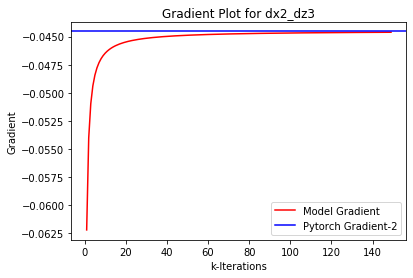

In [12]:
## Plot result to see convergence

fig, ax = plt.subplots()
ax.plot(range(1,k), dx2_dz3_list, c = "red", linestyle = "solid", label = "Model Gradient")

plt.axhline(y = pytorch_grad2, color = 'blue', linestyle = '-', label = "Pytorch Gradient-2")
plt.legend(loc="lower right")
plt.title("Gradient Plot for dx2_dz3")
plt.ylabel("Gradient")
plt.xlabel("k-Iterations")
plt.show()

In [13]:
# Combine results
result = pd.concat([jacob_mat_1, jacob_mat_2, jacob_mat_3], axis=1, join='inner')
result

,dz1,dz2,dz3,dz1,dz2,dz3,dz1,dz2,dz3
dx1,None,tensor(0.3823),tensor(1.1035),[[tensor(0.)]],[[tensor(0.3823)]],[[tensor(0.0193)]],tensor(0.),tensor(0.5161),tensor(0.0185)
dx2,tensor(1.),tensor(0.8828),tensor(-2.5484),[[tensor(1.)]],[[tensor(0.8828)]],[[tensor(-0.0445)]],tensor(1.),tensor(1.1918),tensor(-0.0491)
dx3,None,tensor(0.1766),tensor(0.5097),[[tensor(0.)]],[[tensor(0.1766)]],[[tensor(0.0089)]],tensor(0.),tensor(0.1766),tensor(0.0084)


##### Since the gradient values match, we continue applying NOFAS to our Phys model

# Jubilee's Note to Dr. Schiavazzi: Gradient calculation using pytorch (method 1) have different outputs.
- As you can see below from the plot and from the **result** data above, gradient calculation using pytorch1 and pytorch2 have different values for the third input parameter (z3) which I'm not sure. 
- I'm most positive that we should get rid of the first method and stick to pytorch2 and manual gradient computation but I wanted you to double confirm on this thought.

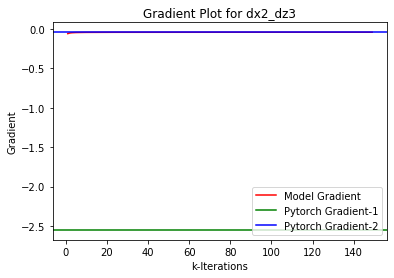

In [16]:
fig, ax = plt.subplots()
ax.plot(range(1,k), dx2_dz3_list, c = "red", linestyle = "solid", label = "Model Gradient")

plt.axhline(y = pytorch_grad1, color = 'g', linestyle = '-', label = "Pytorch Gradient-1")

plt.axhline(y = pytorch_grad2, color = 'blue', linestyle = '-', label = "Pytorch Gradient-2")
plt.legend(loc="lower right")
plt.title("Gradient Plot for dx2_dz3")
plt.ylabel("Gradient")
plt.xlabel("k-Iterations")
plt.show()

### 3. Phys Model without Surrogate

In [18]:
print('')
print('--- Temporary TEST: Physics Example - without NOFAS')
print('')

# Experiment Setting
exp = experiment()
exp.name = "phys_nofasFree"      # str: Name of experiment
exp.flow_type = 'maf'            # str: Type of flow
exp.n_blocks = 5                 # int: Number of layers                            
exp.hidden_size = 100            # int: Hidden layer size for MADE in each layer  
exp.n_hidden = 1                 # int: Number of hidden layers in each MADE      
exp.activation_fn = 'relu'       # str: Actication function used                  
exp.input_order = 'sequential'   # str: Input order for create_mask           
exp.batch_norm_order = True      # boolean: Order to decide if batch_norm is used    
exp.sampling_interval = 5000     # int: How often to sample from normalizing flow

exp.input_size = 3               # int: Dimensionality of input                   
exp.batch_size = 250             # int: Number of samples generated             
exp.true_data_num = 2            # double: number of true model evaluated      
exp.n_iter = 25001               # int: Number of iterations                      
exp.lr = 0.01                    # float: Learning rate                              
exp.lr_decay = 0.9999            # float: Learning rate decay                
exp.log_interval = 100           # int: How often to show loss stat   

exp.run_nofas = False            # boolean: to run experiment with nofas
exp.annealing = False            # boolean: to run experiment with annealing
exp.calibrate_interval = 1000    # int: How often to update surrogate model     
exp.budget = 260                 # int: Total number of true model evaluation

exp.surr_pre_it  = 20000         # int: Number of pre-training iterations for surrogate model
exp.surr_upd_it  = 6000          # int: Number of iterations for the surrogate model update
exp.surr_folder  = "./"
exp.use_new_surr = True          # boolean: to run experiment with nofas

exp.output_dir   = './' + exp.name    # str: output directory location
exp.results_file = 'results.txt'      # str: result text file name
exp.log_file     = 'log.txt'          # str: log text file name
exp.samples_file = 'samples.txt'      # str: sample text file name
exp.seed         = random.randint(0, 10 ** 9)  # int: Random seed used
exp.n_sample     = 5000               # int: Total number of iterations
exp.no_cuda      = True               # boolean: to run experiment with NO cuda

exp.optimizer    = 'RMSprop'          # str: Type of optimizer
exp.lr_scheduler = 'ExponentialLR'    # str: Type of scheduler

exp.device = torch.device('cuda:0' if torch.cuda.is_available() and not exp.no_cuda else 'cpu')

print('--- Running on device: '+ str(exp.device))
print('')

# Define transformation based on normalization rate
trsf_info = [['identity',0.0,0.0,0.0,0.0],
        ['identity',0.0,0.0,0.0,0.0],
        ['linear',-3,3,30.0,80.0]]
trsf = Transformation(trsf_info)        
exp.transform = trsf

# Define model
exp.model = model

# Get data
model.data = np.loadtxt('./data_phys.txt')

# Run experiment without surrogate
exp.surrogate = None

## Define log density
# x: original, untransformed inputs
# model: our model
# transform: our transformation 
def log_density(x, model, transform):
    # Compute transformation log Jacobian
    adjust = transform.compute_log_jacob_func(x)

    batch_size = x.size(0)
    # Get the absolute values of the standard deviations
    stds = torch.abs(model.solve_t(model.defParam)) * model.stdRatio
    Data = torch.tensor(model.data)

    # Get model output without surrogate
    modelOut = model.solve_t(transform.forward(x))

    # Eval LL
    ll1 = -0.5 * np.prod(model.data.shape) * np.log(2.0 * np.pi)
    ll2 = (-0.5 * model.data.shape[1] * torch.log(torch.prod(stds))).item()
    ll3 = 0.0
    for i in range(3):
        ll3 += - 0.5 * torch.sum(((modelOut[:, i].unsqueeze(1) - Data[i, :].unsqueeze(0)) / stds[0, i]) ** 2, dim=1)
    negLL = -(ll1 + ll2 + ll3)
    res = -negLL.reshape(x.size(0), 1) + adjust
    return res

# Assign logdensity
exp.model_logdensity = lambda x: log_density(x, model, trsf)

# Run VI
exp.run()


--- Temporary TEST: Physics Example - without NOFAS

--- Running on device: cpu


--- Running on device: cpu

VI NF (t=1.000): it:     100 | loss: 9.842e+03
--- Saving results at iteration 200
VI NF (t=1.000): it:     200 | loss: 3.976e+03
VI NF (t=1.000): it:     300 | loss: 7.567e+02
--- Saving results at iteration 400
VI NF (t=1.000): it:     400 | loss: 1.483e+02
VI NF (t=1.000): it:     500 | loss: 1.947e+02
--- Saving results at iteration 600
VI NF (t=1.000): it:     600 | loss: 2.955e+02
VI NF (t=1.000): it:     700 | loss: 2.940e+02
--- Saving results at iteration 800
VI NF (t=1.000): it:     800 | loss: 1.907e+02
VI NF (t=1.000): it:     900 | loss: 1.403e+02
--- Saving results at iteration 1000
VI NF (t=1.000): it:    1000 | loss: 1.544e+02
VI NF (t=1.000): it:    1100 | loss: 1.082e+02
--- Saving results at iteration 1200
VI NF (t=1.000): it:    1200 | loss: 9.318e+01
VI NF (t=1.000): it:    1300 | loss: 1.706e+02
--- Saving results at iteration 1400
VI NF (t=1.000): it:   

VI NF (t=1.000): it:   12500 | loss: 1.344e+01
--- Saving results at iteration 12600
VI NF (t=1.000): it:   12600 | loss: 1.367e+01
VI NF (t=1.000): it:   12700 | loss: 1.331e+01
--- Saving results at iteration 12800
VI NF (t=1.000): it:   12800 | loss: 1.330e+01
VI NF (t=1.000): it:   12900 | loss: 1.331e+01
--- Saving results at iteration 13000
VI NF (t=1.000): it:   13000 | loss: 1.315e+01
VI NF (t=1.000): it:   13100 | loss: 1.328e+01
--- Saving results at iteration 13200
VI NF (t=1.000): it:   13200 | loss: 1.322e+01
VI NF (t=1.000): it:   13300 | loss: 1.316e+01
--- Saving results at iteration 13400
VI NF (t=1.000): it:   13400 | loss: 1.316e+01
VI NF (t=1.000): it:   13500 | loss: 1.306e+01
--- Saving results at iteration 13600
VI NF (t=1.000): it:   13600 | loss: 1.339e+01
VI NF (t=1.000): it:   13700 | loss: 1.365e+01
--- Saving results at iteration 13800
VI NF (t=1.000): it:   13800 | loss: 1.296e+01
VI NF (t=1.000): it:   13900 | loss: 1.326e+01
--- Saving results at iterati

--- Saving results at iteration 25000
VI NF (t=1.000): it:   25000 | loss: 1.271e+01

--- Simulation completed!


### 4. Phys Model with Surrogate

In [94]:
print('')
print('--- Temporary TEST: Physics Example - NOFAS')
print('')

# Experiment Setting
exp = experiment()
exp.name = "phys"                # str: Name of experiment
exp.flow_type = 'maf'            # str: Type of flow
exp.n_blocks = 5                 # int: Number of layers                            
exp.hidden_size = 100            # int: Hidden layer size for MADE in each layer  
exp.n_hidden = 1                 # int: Number of hidden layers in each MADE      
exp.activation_fn = 'relu'       # str: Actication function used                  
exp.input_order = 'sequential'   # str: Input order for create_mask           
exp.batch_norm_order = True      # boolean: Order to decide if batch_norm is used    
exp.sampling_interval = 5000     # int: How often to sample from normalizing flow

exp.input_size = 3               # int: Dimensionality of input                   
exp.batch_size = 250             # int: Number of samples generated             
exp.true_data_num = 2            # double: number of true model evaluated      
exp.n_iter = 25001               # int: Number of iterations                      
exp.lr = 0.01                    # float: Learning rate                              
exp.lr_decay = 0.9999            # float: Learning rate decay                
exp.log_interval = 100           # int: How often to show loss stat  

exp.run_nofas = True
exp.annealing = False
exp.calibrate_interval = 1000  # int: How often to update surrogate model          default 1000
exp.budget = 260  # int: Total number of true model evaluation
exp.surr_pre_it = 20000 #:int:    Number of pre-training iterations for surrogate model
exp.surr_upd_it = 6000  #:int:    Number of iterations for the surrogate model update
exp.surr_folder        = "./"
exp.use_new_surr       = True

exp.output_dir   = './' + exp.name
exp.results_file = 'results.txt'
exp.log_file     = 'log.txt'
exp.samples_file = 'samples.txt'
exp.seed         = random.randint(0, 10 ** 9)  # int: Random seed used
exp.n_sample     = 5000  # int: Total number of iterations
exp.no_cuda      = True

exp.optimizer    = 'RMSprop'
exp.lr_scheduler = 'ExponentialLR'

exp.device = torch.device('cuda:0' if torch.cuda.is_available() and not exp.no_cuda else 'cpu')
print('--- Running on device: '+ str(exp.device))
print('')

# Define transformation
trsf_info = [['identity',0.0,0.0,0.0,0.0],
        ['identity',0.0,0.0,0.0,0.0],
        ['linear',-3,3,30.0,80.0]]
trsf = Transformation(trsf_info)        
exp.transform = trsf

# Set model and get data
exp.model = model
model.data = np.loadtxt('./data_phys.txt')

# Define surrogate
exp.surrogate = Surrogate(exp.name, lambda x: model.solve_t(trsf.forward(x)), exp.input_size, 3, 
                          model_folder=exp.surr_folder, limits=torch.Tensor([[0, 2], [0, 10], [-3, 3]]), 
                          memory_len=20, device=exp.device)
surr_filename = exp.surr_folder + exp.name
if exp.use_new_surr or (not os.path.isfile(surr_filename + ".sur")) or (not os.path.isfile(surr_filename + ".npz")):
    print("Warning: Surrogate model files: {0}.npz and {0}.npz could not be found. ".format(surr_filename))
    # 4 samples for each dimension: pre-grid size = 16
#     exp.surrogate.gen_grid(gridnum=4)
    exp.surrogate.gen_grid(gridnum=3)
    exp.surrogate.pre_train(exp.surr_pre_it, 0.03, 0.9999, 500, store=True)
# Load the surrogate
exp.surrogate.surrogate_load()

output_dir = './' + exp.name

# Define log density
def log_density(x, model, surrogate, transform):
    # x contains the original, untransformed inputs
    np.savetxt(output_dir + '/' + exp.name + '_x', x.detach().numpy(), newline="\n")
    # Compute transformation log Jacobian
    adjust = transform.compute_log_jacob_func(x)

    batch_size = x.size(0)
    # Get the absolute values of the standard deviations
    stds = torch.abs(model.solve_t(model.defParam)) * model.stdRatio
    Data = torch.tensor(model.data).to(exp.device)
    
    # Check for surrogate
    if surrogate:
      modelOut = exp.surrogate.forward(x)
    else:
      modelOut = model.solve_t(transform.forward(x))

    # Eval LL
    ll1 = -0.5 * np.prod(model.data.shape) * np.log(2.0 * np.pi)
    ll2 = (-0.5 * model.data.shape[1] * torch.log(torch.prod(stds))).item()
    ll3 = 0.0
    for i in range(3):
        ll3 += - 0.5 * torch.sum(((modelOut[:, i].unsqueeze(1) - Data[i, :].unsqueeze(0)) / stds[0, i]) ** 2, dim=1)
    negLL = -(ll1 + ll2 + ll3)
    res = -negLL.reshape(x.size(0), 1) + adjust
    np.savetxt(output_dir + '/' + exp.name + '_res', res.detach().numpy(), newline="\n")
    return res

# Assign log-density model
exp.model_logdensity = lambda x: log_density(x, model, exp.surrogate, trsf)

# Run VI
exp.run()


--- Temporary TEST: Physics Example - NOFAS

--- Running on device: cpu

Success: Pre-Grid found.

--- Pre-training surrogate model

SUR: PRE: it:       0 | loss: 2.878e+00
SUR: PRE: it:     500 | loss: 2.143e-02
SUR: PRE: it:    1000 | loss: 3.403e-02
SUR: PRE: it:    1500 | loss: 6.723e-02
SUR: PRE: it:    2000 | loss: 4.098e-02
SUR: PRE: it:    2500 | loss: 2.187e-02
SUR: PRE: it:    3000 | loss: 4.471e-02
SUR: PRE: it:    3500 | loss: 1.801e-02
SUR: PRE: it:    4000 | loss: 1.560e-02
SUR: PRE: it:    4500 | loss: 1.199e-02
SUR: PRE: it:    5000 | loss: 1.182e-02
SUR: PRE: it:    5500 | loss: 4.405e-03
SUR: PRE: it:    6000 | loss: 1.455e-02
SUR: PRE: it:    6500 | loss: 7.392e-03
SUR: PRE: it:    7000 | loss: 3.385e-03
SUR: PRE: it:    7500 | loss: 1.512e-02
SUR: PRE: it:    8000 | loss: 7.596e-03
SUR: PRE: it:    8500 | loss: 3.101e-03
SUR: PRE: it:    9000 | loss: 9.216e-03
SUR: PRE: it:    9500 | loss: 7.438e-03
SUR: PRE: it:   10000 | loss: 3.331e-03
SUR: PRE: it:   10500 | lo

SUR: UPD: it:    3000 | loss: 2.828e-02
SUR: UPD: it:    3500 | loss: 2.795e-02
SUR: UPD: it:    4000 | loss: 2.777e-02
SUR: UPD: it:    4500 | loss: 2.767e-02
SUR: UPD: it:    5000 | loss: 2.762e-02
SUR: UPD: it:    5500 | loss: 2.758e-02

--- Surrogate model updated

VI NF (t=1.000): it:    5000 | loss: 6.128e+02
VI NF (t=1.000): it:    5100 | loss: 3.791e+01
--- Saving results at iteration 5200
VI NF (t=1.000): it:    5200 | loss: 2.214e+01
VI NF (t=1.000): it:    5300 | loss: 2.036e+01
--- Saving results at iteration 5400
VI NF (t=1.000): it:    5400 | loss: 1.991e+01
VI NF (t=1.000): it:    5500 | loss: 1.628e+01
--- Saving results at iteration 5600
VI NF (t=1.000): it:    5600 | loss: 3.375e+01
VI NF (t=1.000): it:    5700 | loss: 1.804e+01
--- Saving results at iteration 5800
VI NF (t=1.000): it:    5800 | loss: 1.616e+01
VI NF (t=1.000): it:    5900 | loss: 1.888e+01
--- Saving results at iteration 6000

--- Updating surrogate model

Std before inflation -> Std after inflation


--- Saving results at iteration 11200
VI NF (t=1.000): it:   11200 | loss: 8.262e+00
VI NF (t=1.000): it:   11300 | loss: 8.345e+00
--- Saving results at iteration 11400
VI NF (t=1.000): it:   11400 | loss: 8.299e+00
VI NF (t=1.000): it:   11500 | loss: 8.185e+00
--- Saving results at iteration 11600
VI NF (t=1.000): it:   11600 | loss: 8.205e+00
VI NF (t=1.000): it:   11700 | loss: 8.006e+00
--- Saving results at iteration 11800
VI NF (t=1.000): it:   11800 | loss: 8.015e+00
VI NF (t=1.000): it:   11900 | loss: 7.950e+00
--- Saving results at iteration 12000

--- Updating surrogate model

Std before inflation -> Std after inflation
5.648e-02 -> 8.101e-02
5.597e-02 -> 4.461e-02
1.413e-01 -> 1.413e-01

SUR: UPD: it:       0 | loss: 1.698e-02
SUR: UPD: it:     500 | loss: 2.345e-02
SUR: UPD: it:    1000 | loss: 2.031e-02
SUR: UPD: it:    1500 | loss: 1.864e-02
SUR: UPD: it:    2000 | loss: 1.826e-02
SUR: UPD: it:    2500 | loss: 1.869e-02
SUR: UPD: it:    3000 | loss: 1.805e-02
SUR: UPD:

VI NF (t=1.000): it:   17700 | loss: 8.066e+00
--- Saving results at iteration 17800
VI NF (t=1.000): it:   17800 | loss: 7.991e+00
VI NF (t=1.000): it:   17900 | loss: 8.044e+00
--- Saving results at iteration 18000

--- Updating surrogate model

Std before inflation -> Std after inflation
8.472e-02 -> 1.976e-01
2.813e-02 -> 1.388e-01
1.240e-01 -> 1.240e-01

SUR: UPD: it:       0 | loss: 1.982e-02
SUR: UPD: it:     500 | loss: 3.887e-02
SUR: UPD: it:    1000 | loss: 3.254e-02
SUR: UPD: it:    1500 | loss: 2.662e-02
SUR: UPD: it:    2000 | loss: 2.565e-02
SUR: UPD: it:    2500 | loss: 2.448e-02
SUR: UPD: it:    3000 | loss: 2.400e-02
SUR: UPD: it:    3500 | loss: 2.394e-02
SUR: UPD: it:    4000 | loss: 2.391e-02
SUR: UPD: it:    4500 | loss: 2.388e-02
SUR: UPD: it:    5000 | loss: 2.386e-02
SUR: UPD: it:    5500 | loss: 2.386e-02

--- Surrogate model updated

VI NF (t=1.000): it:   18000 | loss: 8.273e+00
VI NF (t=1.000): it:   18100 | loss: 7.797e+00
--- Saving results at iteration 18

SUR: UPD: it:     500 | loss: 1.830e-01
SUR: UPD: it:    1000 | loss: 1.345e-01
SUR: UPD: it:    1500 | loss: 1.244e-01
SUR: UPD: it:    2000 | loss: 1.238e-01
SUR: UPD: it:    2500 | loss: 1.230e-01
SUR: UPD: it:    3000 | loss: 1.224e-01
SUR: UPD: it:    3500 | loss: 1.222e-01
SUR: UPD: it:    4000 | loss: 1.221e-01
SUR: UPD: it:    4500 | loss: 1.221e-01
SUR: UPD: it:    5000 | loss: 1.220e-01
SUR: UPD: it:    5500 | loss: 1.220e-01

--- Surrogate model updated

VI NF (t=1.000): it:   24000 | loss: 2.198e+01
VI NF (t=1.000): it:   24100 | loss: 8.043e+00
--- Saving results at iteration 24200
VI NF (t=1.000): it:   24200 | loss: 7.933e+00
VI NF (t=1.000): it:   24300 | loss: 7.971e+00
--- Saving results at iteration 24400
VI NF (t=1.000): it:   24400 | loss: 7.971e+00
VI NF (t=1.000): it:   24500 | loss: 7.792e+00
--- Saving results at iteration 24600
VI NF (t=1.000): it:   24600 | loss: 7.757e+00
VI NF (t=1.000): it:   24700 | loss: 7.741e+00
--- Saving results at iteration 24800
VI

In [95]:
from IPython.display import IFrame
IFrame("./data_plot_phys_25000_0_1.pdf", width=200, height=155)